In [21]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir

In [22]:
class particle:
    def __init__(self, pid, fourvector, virtual_photon,ThetaPQ):
        #work in frame that is aligned with photon
        #the photon is aligned with z-direction and has 4-momentum q= (0,0,sqrt(Nu2+Q2),Nu) (note q2 = -Q2)        
        self.virtual_photon = virtual_photon
        Nu = virtual_photon.E()
        Q2 = -virtual_photon.M2()
        self.proton = ROOT.TLorentzVector()
        self.proton.SetPxPyPzE(0,0,0, 0.938)
        self.W = (virtual_photon + self.proton).M()
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        part1 = virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = virtual_photon.Vect().Cross(fourvector.Vect()).Unit()
        sign  = np.sign(part1.Dot(fourvector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2))
        #print ' Angle my way ', self.PhiPQ
        #print 'Hayk (radians) ' , PhiPQ*np.pi/180.0
        
        photon_pz = np.sqrt(Nu*Nu+Q2) #direction is positive by definition
        self.bcm = photon_pz/(Nu + 0.938)#photon-nucleon center-of-mass velocity 
        self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
        
        self.LorentzVector = fourvector #hadron four-vector
        self.PhiLab = self.LorentzVector.Phi()
        self.E = self.LorentzVector.E() #energy in lab frame
        self.vector = self.LorentzVector.Vect()
        self.Pt = self.vector.Perp(virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.vector.Dot(virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
        self.y_star = self.y - self.ycm
        self.Pl_star = self.mT*np.sinh(self.y_star)
        self.Xf = 2.0*self.Pl_star/self.W 
        self.pid = pid
        self.Zh = self.E/Nu
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        #print 'My COSPQ' , np.arctan(self.Pt/self.Pl)
        #print 'Hayk COSPQ', self.ThetaPQ
        
    def redefine(self, new_virtual_photon):
        #this methods recalculates variables that depend on virtual photon direction
        #this helps for event mixing. 
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        part1 = new_virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = new_virtual_photon.Vect().Cross(self.LorentzVector.Vect()).Unit()
       
        sign  = np.sign(part1.Dot(self.LorentzVector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2)) 
        self.Pt = self.LorentzVector.Vect().Perp(new_virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.LorentzVector.Vect().Dot(new_virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        self.virtual_photon = new_virtual_photon
        
        return
        
        
        
    def print_properties(self):
        print ('Hello, let me introduce myself, i am particle pid = ' , self.pid, ' with index ', self.index, ', from event  #', self.ievt, ' Nu and W', self.Nu, ' ' , self.W)
        print ('zh = ', self.Zh, ' phi_pq= ', self.PhiPQ, ' theta_pq=' , self.ThetaPQ, 'E = ', self.E, ' xf', self.Xf,'Pt ', self.Pt, ' Pl= ', self.Pl, ' rapidity=' ,  self.y)
        print ('pid = ' , self.pid)

In [36]:

def getDataframes(filename, Target=1,maxevents=1e9,tree_name='ntuple_data',isMC=False):
    dphi = np.array([])
    ParticlesFromPrevious = []
    try:
        myfile = TFile.Open('%s'%filename,'READ')
        myfile.Print()
    except:
        print("could not open file")
        
    #myfile.Print()
    mytree = myfile.Get(tree_name)
        
    print (filename, ' has ', mytree.GetEntries(), ' entries')
    tupla = {}
    tupla['dphi'] = []
    tupla['dphi_lab'] = []
    tupla['drap'] = []
    
    tupla['h1_z'] = [] 
    tupla['h2_z'] = []
    tupla['h1_cm_pt'] = []
    tupla['h2_cm_pt'] = []
    tupla['h1_xf'] = []
    tupla['h2_xf'] = []
    tupla['h1_rap'] = []
    
    tupla['ycm'] = []

    tupla['h2_rap'] = []
    tupla['h1_pid'] = []
    tupla['h2_pid'] = []
    tupla['h1_cm_ph'] = []
    tupla['h2_cm_ph'] = []
    tupla['h1_cm_th'] = []  
    tupla['h2_cm_th'] = []  

    tupla['pair_mass'] = []
    tupla['pair_pt'] = []
    tupla['mx_eh1h2x'] = []
    tupla['mx_eh1x'] = []
    tupla['mx_eh2x'] = []

    tupla['t']  = []
    tupla['Q2'] = [] 
    tupla['nu'] = []
    tupla['W']  = []
    tupla['x'] = []
    tupla['u']  = []
    tupla['h1_ph'] = []
    tupla['h1_th'] = []
    tupla['h2_ph'] = []
    tupla['h2_th'] = []
    
    tupla_mix = {}
    tupla_mix['dphi'] = []
    tupla_mix['dphi_lab'] = []
    tupla_mix['drap'] = []
    
    tupla_mix['h1_z'] = []
    tupla_mix['h2_z'] = []
    tupla_mix['h1_cm_pt'] = []
    tupla_mix['h2_cm_pt'] = []
    tupla_mix['h1_xf'] = []
    tupla_mix['h2_xf'] = []
    tupla_mix['h1_rap'] = []
    tupla_mix['ycm'] = []

    tupla_mix['h2_rap'] = []
    tupla_mix['h1_pid'] = []
    tupla_mix['h2_pid'] = []
    tupla_mix['h1_cm_ph']   = []
    tupla_mix['h2_cm_ph'] = []
    tupla_mix['h1_cm_th'] = []
    tupla_mix['h2_cm_th'] = []

    tupla_mix['pair_mass'] = []
    tupla_mix['pair_pt'] = []
    tupla_mix['mx_eh1h2x'] = []
    tupla_mix['mx_eh1x'] = []
    tupla_mix['mx_eh2x'] = []

    tupla_mix['t']  = []
    tupla_mix['Q2'] = []
    tupla_mix['nu'] = []
    tupla_mix['W']  = []
    tupla_mix['x'] = []
    tupla_mix['u']  = []
    tupla_mix['h1_ph'] = []
    tupla_mix['h1_th'] = []
    tupla_mix['h2_ph'] = []
    tupla_mix['h2_th'] = []
    tupla_mix['dphi_norot'] = [] #save variable before rotation to new virtual photon frame
    tupla_mix['h2_cm_ph_norot'] = [] #save variable before rotation to new virtual photon frame
    tupla_mix['h2_cm_th_norot'] = [] #save variable before rotation to new virtual photon frame

    
    
    
    tupla_trigger = {}
    tupla_trigger['h1_pid'] = []
    tupla_trigger['h1_xf'] = []
    tupla_trigger['h1_xf_default'] = []
    tupla_trigger['h1_z']  = []
    tupla_trigger['h1_cm_pt'] = []
    tupla_trigger['h1_rap']  = []
    tupla_trigger['ycm'] = []
    tupla_trigger['Q2'] = []
    tupla_trigger['x'] = []
    tupla_trigger['nu'] = []
    tupla_trigger['W'] = []
    tupla_trigger['h1_cm_ph'] = []
    tupla_trigger['h1_cm_th'] = []
    tupla_trigger['TargType'] = []
    tupla_trigger['missing_mass'] = []
    tupla_trigger['h1_ph'] = []
    tupla_trigger['h1_th'] = []
    
    
    start = time.time()
    print('About to loop over ', mytree.GetEntries() , ' entries')
    for ievt  in range(mytree.GetEntries()):
        #if(mytree.Q2<1.0): continue
        #print('Event%i, Q2=%2.2f, W=%2.2f'%(ievt,mytree.Q2,mytree.W))

        mytree.GetEntry(ievt)   
        if mytree.W<2.05 or mytree.Q2<1.0: continue
        
        if ievt>maxevents: break
        #print('pass Q2, W, maxevents cut')
        #print('target type is ', mytree.TargType)
        #print(isMC)
        #print(mytree.TargType)
        #print(mytree.vze)
        if(mytree.vze>-32 and mytree.vze<-27):
            TargType=1
        elif(mytree.vze>-27 and mytree.vze<-23):
            TargType=2
        else:
            TargType=0
        #print (TargType,  ' ' , Target)
        if not(isMC) and (TargType!=Target): continue
        
        #print('PASO all cuts')
        W = mytree.W
        Nu = mytree.Nu
        #get electron momentum:
        Pe = np.sqrt(mytree.Pex*mytree.Pex + mytree.Pey*mytree.Pey+ mytree.Pez*mytree.Pez)
        scattered_e = ROOT.TLorentzVector()
        scattered_e.SetPxPyPzE(mytree.Pex, mytree.Pey, mytree.Pez, Pe)
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        virtual_photon  = incoming_e - scattered_e 
        virtual_photon_unitvector = virtual_photon.Vect().Unit()
        proton = ROOT.TLorentzVector()
        proton.SetPxPyPzE(0,0,0, 0.938)
        
        ##alternative calculation of virtual photon
        #scattered electron
        #E    = 5.014
        #Eprime = E-Nu
        #phi_e = -scattered_e.Vect().Phi()
        #alt_scattered_e = ROOT.TLorentzVector()
        #cos_thetae = 1-mytree.Q2/(2*E*Eprime)
        #sin_thetae = np.sqrt(1-cos_thetae*cos_thetae)
        #alt_scattered_e.SetPxPyPzE(Eprime*sin_thetae*np.cos(phi_e),
        #                       Eprime*sin_thetae*np.sin(phi_e),
        #                       Eprime*cos_thetae,
        #                       Eprime)
        #alt_virtual_photon  = incoming_e - alt_scattered_e
        
        #print 'Comparing normal and alternative virtual photons momentum'
        #print 'virtual ',virtual_photon.Px(), ' ', virtual_photon.Py(), ' ', virtual_photon.Pz(), ' ',virtual_photon.E()
        #print 'alt ' ,alt_virtual_photon.Px(), ' ', alt_virtual_photon.Py(), ' ',alt_virtual_photon.Pz(), ' ',alt_virtual_photon.E()
        #################################################
        
        
        
        #photon-nucleon center-of-mass energy and rapidity
        #the photon is aligned with z-direction and has 4-momentum q= (0,0,sqrt(Nu2+Q2),Nu) (note q2 = -Q2)
        
     
        #print 'W ',  W , 'electron W ', e_tree.W
        #print (virtual_photon + proton).M()
        particles = []
        #print (' Entering main loop over particles')
        for i in range(len(mytree.pid)):
            #print(mytree.pid[i])
            if (abs(mytree.pid[i]) !=211 and mytree.pid[i]!=2212): continue
            i_lv = ROOT.TLorentzVector()    
            i_lv.SetPxPyPzE(mytree.Px[i],mytree.Py[i],mytree.Pz[i],mytree.Zh[i]*Nu)
#            print i_lv.Phi(), '   ', mytree.Phi[i]*np.pi/180.0
            
            
            i_part = particle(mytree.pid[i], i_lv, virtual_photon, mytree.ThetaPQ[i] )
            #print i_part.LorentzVector.Phi()
            #print mytree.Phi[i]*np.pi/180.0
            #print i_part.LorentzVector.Theta(), '   ', mytree.Theta[i]*np.pi/180.0

            particles.append(i_part)                
            X = (virtual_photon + proton -  i_part.LorentzVector) #unobserved hadronic system

            if i_part.Zh > 0.4: #only save triggers and do correlations if they have z>0.4
            #if i_part.Pt>1.0: #only save triggers if pT>1.0 
                tupla_trigger['TargType'].append(mytree.TargType)
                tupla_trigger['h1_pid'].append(i_part.pid)
                tupla_trigger['h1_xf'].append(i_part.Xf)
                tupla_trigger['h1_xf_default'].append(-1)
                tupla_trigger['h1_z'].append(i_part.Zh)
                tupla_trigger['h1_cm_pt'].append(i_part.Pt)
                tupla_trigger['h1_rap'].append(i_part.y_star)
                tupla_trigger['ycm'].append(i_part.ycm)
                tupla_trigger['h1_cm_ph'].append(i_part.PhiPQ)
                tupla_trigger['h1_cm_th'].append(i_part.ThetaPQ)
                tupla_trigger['missing_mass'].append(X.M())
                tupla_trigger['Q2'].append(mytree.Q2)
                tupla_trigger['x'].append(mytree.Xb)
                tupla_trigger['nu'].append(mytree.Nu)
                tupla_trigger['W'].append(mytree.W)
                tupla_trigger['h1_ph'].append(mytree.PhiLab[i])
                tupla_trigger['h1_th'].append(mytree.ThetaLab[i])#i_part.LorentzVector.Theta())
                #print 'mytree.Pt[i] ' , mytree.Pt[i], ' check: ' ,i_part.Vector.Perp(virtual_photon_unitvector)
                
                #print('Testing theta PQ', mytree.ThetaPQ[i],  ' '  , 180.0*i_part.ThetaPQ/np.pi)
                #print('Testing phi PQ', mytree.PhiPQ[i],  ' '  , 180.0*i_part.PhiPQ/np.pi)

                for j in range(len(mytree.pid)): 
                    if i==j: continue
                    if (abs(mytree.pid[j]) !=211 and mytree.pid[j]!=2212): continue
                    j_lv = ROOT.TLorentzVector()    
                    j_lv.SetPxPyPzE(mytree.Px[j],mytree.Py[j],mytree.Pz[j],mytree.Zh[j]*Nu)
                    j_part = particle(mytree.pid[j], j_lv, virtual_photon, mytree.ThetaPQ[j] )
                    
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-j_part.PhiPQ))
                    dphi_lab = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiLab-j_part.PhiLab))

                    
                    dy = i_part.y-j_part.y
                    deta = dy
                    dipion = i_part.LorentzVector+j_part.LorentzVector
                    X = (virtual_photon + proton - dipion) #unobserved hadronic system
                    X1 = (virtual_photon + proton - i_part.LorentzVector)
                    X2 = (virtual_photon + proton - j_part.LorentzVector)

                    tupla['dphi'].append(dphi)
                    tupla['dphi_lab'].append(dphi_lab)
                    tupla['drap'].append(dy)
                    tupla['h1_z'].append(i_part.Zh)
                    tupla['h2_z'].append(j_part.Zh)
                    tupla['h1_cm_pt'].append(i_part.Pt)
                    tupla['h2_cm_pt'].append(j_part.Pt)
                    tupla['h1_xf'].append(i_part.Xf)
                    tupla['h2_xf'].append(j_part.Xf)
                    
                    
                    tupla['h1_rap'].append(i_part.y_star)
                    tupla['ycm'].append(i_part.ycm)
                    tupla['h2_rap'].append(j_part.y_star)
                    tupla['h1_pid'].append(i_part.pid)
                    tupla['h2_pid'].append(j_part.pid)
                    tupla['h1_cm_ph'].append(i_part.PhiPQ)
                    tupla['h2_cm_ph'].append(j_part.PhiPQ)
                    tupla['h1_cm_th'].append(i_part.ThetaPQ)
                    tupla['h2_cm_th'].append(j_part.ThetaPQ)
                    tupla['pair_mass'].append(dipion.M())
                    tupla['pair_pt'].append( dipion.Vect().Perp(virtual_photon_unitvector))
                    tupla['mx_eh1h2x'].append(X.M())
                    tupla['mx_eh1x'].append(X1.M())
                    tupla['mx_eh2x'].append(X2.M())
                    tupla['t'].append( -(virtual_photon- dipion).M2())
                    tupla['Q2'].append(mytree.Q2)
                    tupla['x'].append(mytree.Xb)
                    tupla['nu'].append(mytree.Nu)
                    tupla['W'].append(mytree.W)
                    tupla['u'].append(-(scattered_e-proton).M2())
                    tupla['h1_ph'].append(mytree.PhiLab[i])
                    tupla['h1_th'].append(mytree.ThetaLab[i])
                    tupla['h2_ph'].append(mytree.PhiLab[j])
                    tupla['h2_th'].append(mytree.ThetaLab[j])
                    #end loop over secondary loop    
                #print '//////// Entering mixed event correlations with # ', len(ParticlesFromPrevious) , ' paticles in previous event'
                for mixparticle in ParticlesFromPrevious:
                    
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    tupla_mix['dphi_norot'].append(dphi)
                    tupla_mix['h2_cm_ph_norot'].append(mixparticle.PhiPQ)
                    tupla_mix['h2_cm_th_norot'].append(mixparticle.ThetaPQ)

                    mixparticle.redefine(virtual_photon) #recalculates variables in this' event photon frame (not in the previous one)
                    #dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    #print 'dphi_pq after redefinition: ', dphi , ' phi_pq ', mixparticle.PhiPQ
                    
                    dipion = i_part.LorentzVector+mixparticle.LorentzVector
                    X = (virtual_photon + proton - dipion)
                    X1 = (virtual_photon + proton - i_part.LorentzVector)
                    X2 = (virtual_photon + proton - mixparticle.LorentzVector)

                    #recalculate the phi_pq. It has to be with respect to the photon direction
                    
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    dphi_lab = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiLab-mixparticle.PhiLab))

                    dy = i_part.y-mixparticle.y
                    deta = dy#i_part.ThetaPQ-mixparticle.ThetaPQ
                    tupla_mix['dphi'].append(dphi)
                    tupla_mix['dphi_lab'].append(dphi_lab)
                    tupla_mix['drap'].append(dy)
                    tupla_mix['h1_z'].append(i_part.Zh)
                    tupla_mix['h2_z'].append(mixparticle.Zh)
                    tupla_mix['h1_cm_pt'].append(i_part.Pt)
                    tupla_mix['h2_cm_pt'].append(mixparticle.Pt)
                    tupla_mix['h1_xf'].append(i_part.Xf)
                    tupla_mix['h2_xf'].append(mixparticle.Xf)
                    
                    
                    tupla_mix['h1_rap'].append(i_part.y_star)
                    tupla_mix['ycm'].append(i_part.ycm)
                    tupla_mix['h2_rap'].append(mixparticle.y_star)
                    tupla_mix['h1_pid'].append(i_part.pid)
                    tupla_mix['h2_pid'].append(mixparticle.pid)
                    tupla_mix['h1_cm_ph'].append(i_part.PhiPQ)
                    tupla_mix['h2_cm_ph'].append(mixparticle.PhiPQ)
                    tupla_mix['h1_cm_th'].append(i_part.ThetaPQ)
                    tupla_mix['h2_cm_th'].append(mixparticle.ThetaPQ)
                    
                    tupla_mix['pair_mass'].append(dipion.M())
                    tupla_mix['pair_pt'].append( dipion.Vect().Perp(virtual_photon_unitvector))
                    tupla_mix['mx_eh1h2x'].append(X.M())
                    tupla_mix['mx_eh1x'].append(X1.M())
                    tupla_mix['mx_eh2x'].append(X2.M())

                    tupla_mix['t'].append( -(virtual_photon- dipion).M2())
                    tupla_mix['Q2'].append(mytree.Q2)
                    tupla_mix['x'].append(mytree.Xb)
                    tupla_mix['nu'].append(mytree.Nu)
                    tupla_mix['W'].append(mytree.W)
                    tupla_mix['u'].append(-(scattered_e-proton).M2())
                    tupla_mix['h1_ph'].append(i_part.LorentzVector.Phi())
                    tupla_mix['h1_th'].append(mytree.ThetaLab[i])
                    tupla_mix['h2_ph'].append(mixparticle.LorentzVector.Phi())
                    tupla_mix['h2_th'].append(mytree.ThetaLab[j])
        ParticlesFromPrevious = particles
        #print ' going for next event'    
        #print ' particles in event', len(particles
        ##end loop over events correlations    
    end = time.time()
    print ('Processed in',  end-start, 'seconds')
    
    df = pd.DataFrame(tupla)
    df_mix= pd.DataFrame(tupla_mix)
    df_trigger = pd.DataFrame(tupla_trigger)
    print ('Number of triggers with z>0.4,  ', df.query('h1_z>0.4').shape[0])
    print ('Number of pairs with z>0.4, ' ,df_trigger.query('h1_z>0.4').shape[0]) 
    myfile.Close()
    return df, df_mix, df_trigger

In [37]:
#for a particle on-shell:
# E = mT cosh y 
# pz = mT sinh y
#mT2 = m2 + pt2
# rapidity in the ion-at-rest frame, with the photon direction is 
# y = 0.5 * ln( (E+pz)/(E-pz))
#rapidity of the target in the lab frame = 0 (at rest)
# y = y* + ycm
#bcm = az + bz/ a0 + b0 
#bcm = photon_z / Nu + m_{p}
#ycm = 0.5 * ln( 1+bcm/1-bcm)
#energy of the photon = Nu
#momentum of the photon (magnitude) = sqrt(Nu2 + Q2) 
#q2 = -Q2. (four-momentum transfer)

## Create dataframe df

In [38]:
df = {}
df_mc = {}

## D sim

In [ ]:
%%time
path = '/home/miguel/di-hadron/simul/D2_pb1/ROOT/'
Files = listdir(path) 
df_mc['D'],df_mc['D_mix'], df_mc['D_trigger'] = [None,None,None]
for i,name in enumerate(Files):
    print('file number ', i, ' from a total of ' len(Files))
    print(name)
    if( 'root' not in name): continue
    
    filename = path+name
    print(filename)
    pairs, pairs_mix, trigger = getDataframes(filename,tree_name='ntuple_sim',Target=1,isMC=True)
    df_mc['D'] = pd.concat([ df_mc['D'], pairs])
    df_mc['D_mix'] = pd.concat([ df_mc['D_mix'], pairs_mix])
    df_mc['D_trigger'] = pd.concat([ df_mc['D_trigger'], trigger])

    print('Entries in the dataframe so far are ', df_mc['D'].shape[0])
    print('Entries in the MIXED dataframe so far are ', df_mc['D_mix'].shape[0])
    print('Entries in the trigger dataframe so far are ', df_mc['D_trigger'].shape[0])

## C simulation

In [ ]:
%%time
path = '/home/miguel/di-hadron/simul/C1/ROOT/'
Files = listdir(path) 
df_mc['C'],df_mc['C_mix'], df_mc['C_trigger'] = [None,None,None]
for name in Files:
    print(name)
    if( 'root' not in name): continue
    
    filename = path+name
    print(filename)
    pairs, pairs_mix, trigger = getDataframes(filename,tree_name='ntuple_sim',Target=1,isMC=True)
    df_mc['C'] = pd.concat([ df_mc['C'], pairs])
    df_mc['C_mix'] = pd.concat([ df_mc['C_mix'], pairs_mix])
    df_mc['C_trigger'] = pd.concat([ df_mc['C_trigger'], trigger])

    print('Entries in the dataframe so far are ', df_mc['C'].shape[0])
    print('Entries in the MIXED dataframe so far are ', df_mc['C_mix'].shape[0])
    print('Entries in the trigger dataframe so far are ', df_mc['C_trigger'].shape[0])


In [ ]:
df_mc['D'].hist(figsize=(20,20),bins=100)
plt.show()

In [ ]:
df_mc['D'].hist(figsize=(20,20),bins=100)

df_mc['C'].hist(figsize=(20,20),bins=100)
plt.show()

## Fe Data

In [1]:
path = '/home/miguel/di-hadron/data/fe/'

Files = listdir(path) 
df['Fe'],df['Fe_mix'], df['Fe_trigger'] = [None,None,None]
df['D_Fe'],df['D_Fe_mix'], df['D_Fe_trigger'] = [None,None,None]

for name in Files:
    filename = path+name
    print (filename)
    if( 'root' not in name): continue

    pairs, pairs_mix, trigger = getDataframes(filename,Target=2)
    df['Fe'] = pd.concat([ df['Fe'], pairs])
    df['Fe_mix'] = pd.concat([ df['Fe_mix'], pairs_mix])
    df['Fe_trigger'] = pd.concat([ df['Fe_trigger'], trigger])
    pairs, pairs_mix, trigger = getDataframes(filename,Target=1)
    df['D_Fe'] = pd.concat([ df['D_Fe'], pairs])
    df['D_Fe_mix'] = pd.concat([ df['D_Fe_mix'], pairs_mix])
    df['D_Fe_trigger'] = pd.concat([ df['D_Fe_trigger'], trigger])
    
    
    print('Entries in the dataframe so far are ', df['D_Fe'].shape[0])
    print('Entries in the MIXED dataframe so far are ', df['D_Fe_mix'].shape[0])
    print('Entries in the trigger dataframe so far are ', df['D_Fe_trigger'].shape[0])

NameError: name 'listdir' is not defined

1815640

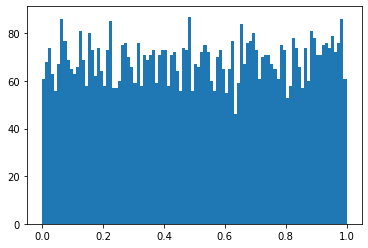

In [27]:
plt.hist(df['D_Fe']['h1_ph'],bins=100,range=(0,1.0))
df['D_Fe'].shape[0]

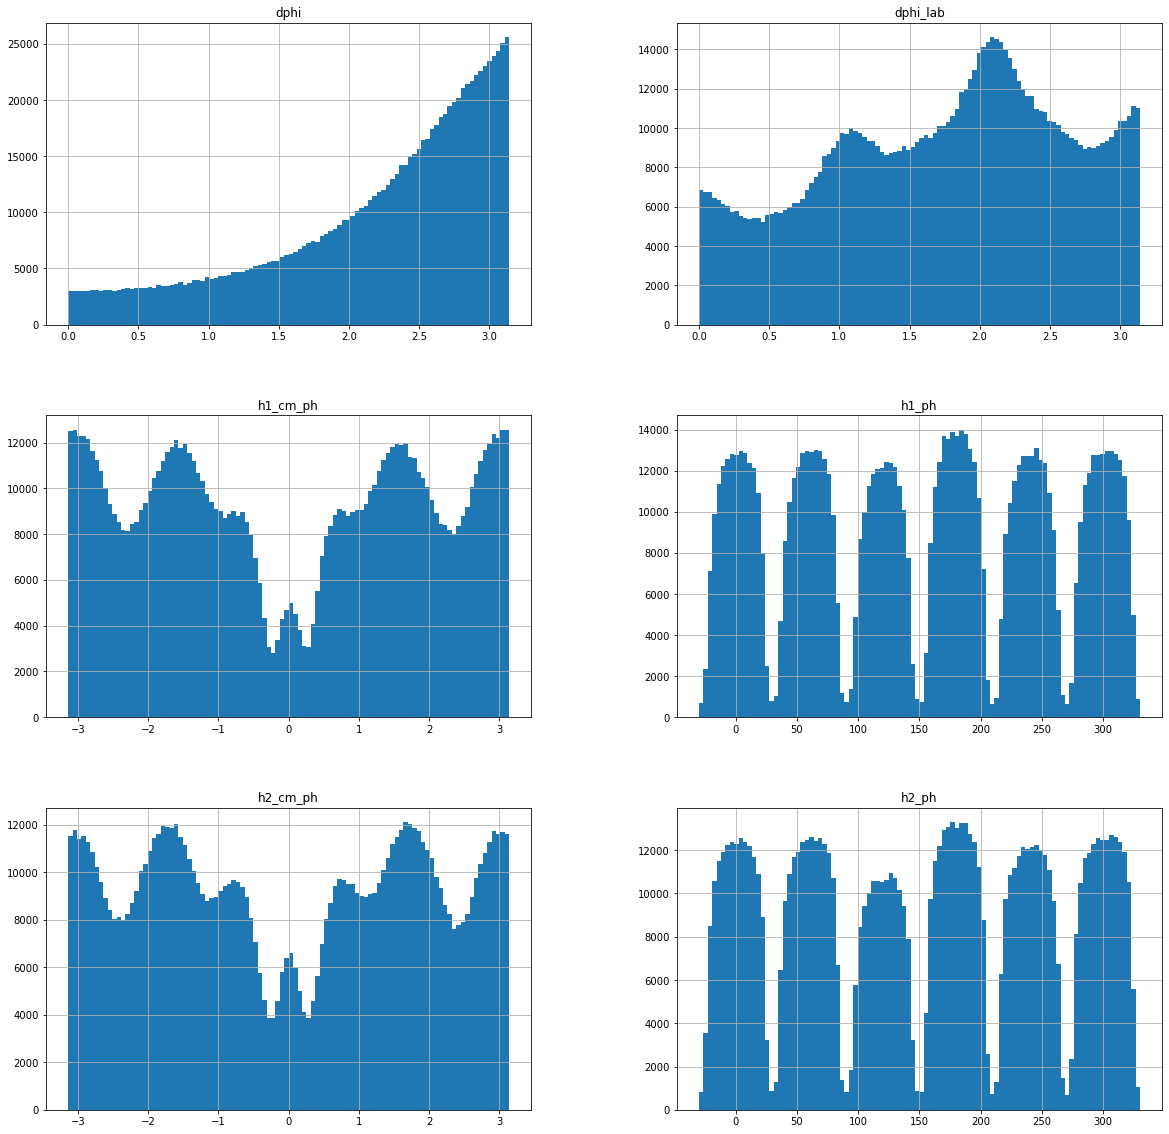

In [28]:
df['D_Fe'].query('h2_z>0.2').hist(figsize=(20,20),bins=100,column=['dphi_lab','dphi','h1_ph','h2_ph','h1_cm_ph','h2_cm_ph'])
plt.show()

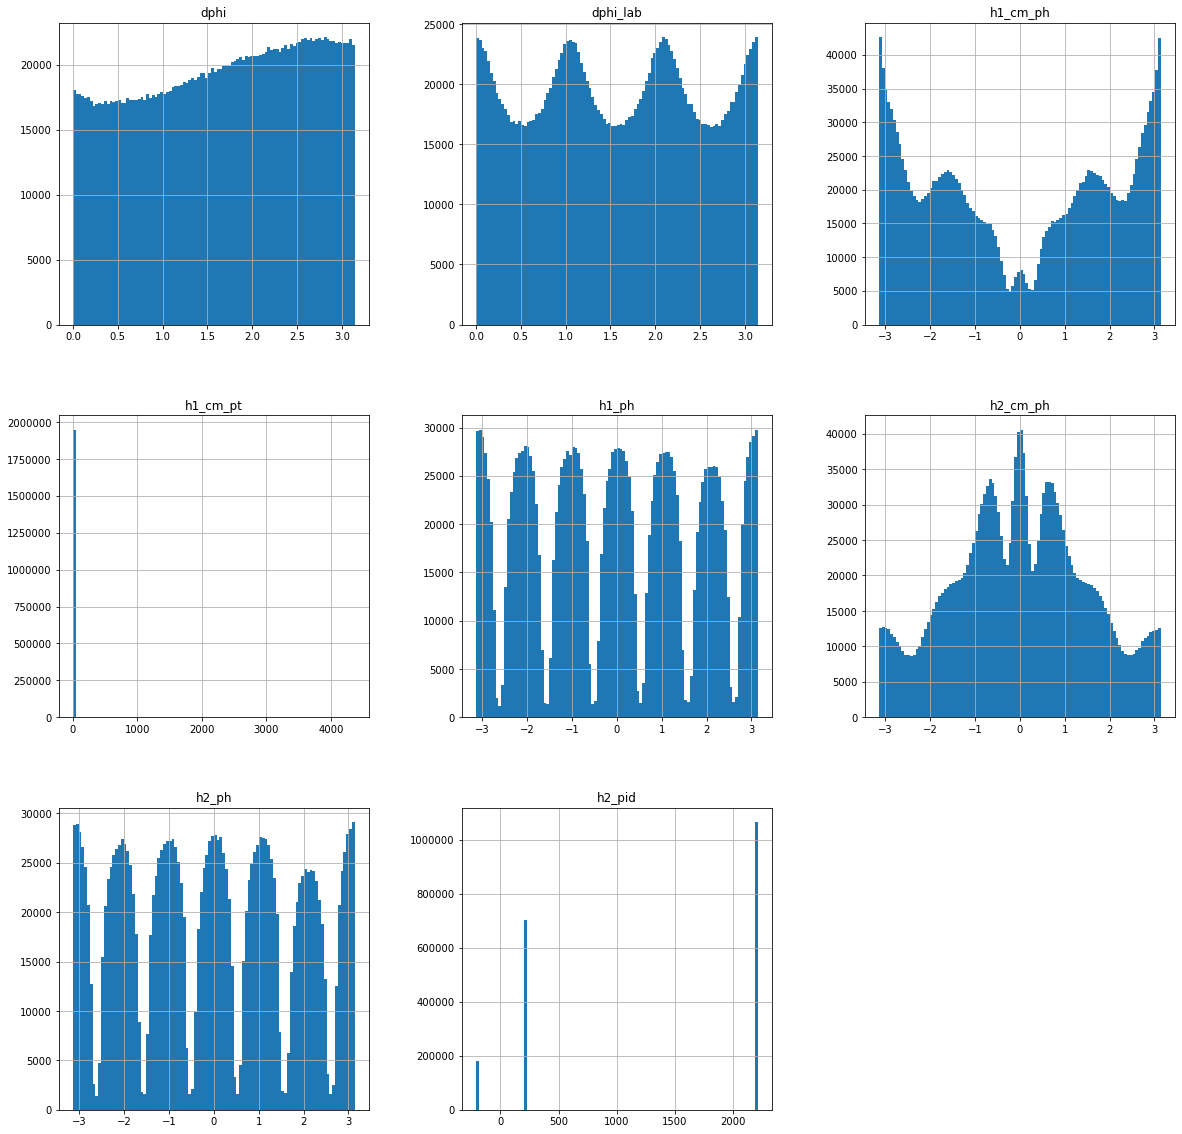

In [29]:
df['D_Fe_mix'].query('h2_z>0.2').hist(figsize=(20,20),bins=100,column=['h1_cm_pt','dphi_lab','dphi','h1_ph','h2_ph','h1_cm_ph','h2_cm_ph','h2_pid'])
plt.show()

In [ ]:
path = '/home/miguel/di-hadron/data/pb/
Files = listdir(path) 
df['Pb'],df['Pb_mix'], df['Pb_trigger'] = [None,None,None]
df['D_Pb'],df['D_Pb_mix'], df['D_Pb_trigger'] = [None,None,None]

for name in Files:
    filename = path+name
    print (filename)
    if( 'root' not in name): continue
    pairs, pairs_mix, trigger = getDataframes(filename,Target=2)
    df['Pb'] = pd.concat([ df['Pb'], pairs])
    df['Pb_mix'] = pd.concat([ df['Pb_mix'], pairs_mix])
    df['Pb_trigger'] = pd.concat([ df['Pb_trigger'], trigger])
    pairs, pairs_mix, trigger = getDataframes(filename,Target=1)
    df['D_Pb'] = pd.concat([ df['D_Pb'], pairs])
    df['D_Pb_mix'] = pd.concat([ df['D_Pb_mix'], pairs_mix])
    df['D_Pb_trigger'] = pd.concat([ df['D_Pb_trigger'], trigger])
    
    print('Entries in the dataframe so far are ', df['D_Pb'].shape[0])
    print('Entries in the MIXED dataframe so far are ', df['D_Pb_mix'].shape[0])
    print('Entries in the trigger dataframe so far are ', df['D_Pb_trigger'].shape[0])

# C data

In [39]:
#path = '/home/miguel/di-hadron/data/ca/
path = '/home/miguel/di-hadron/data/merged/ca/'
Files = listdir(path) 
df['C'],df['C_mix'], df['C_trigger'] = [None,None,None]
df['D_C'],df['D_C_mix'], df['D_C_trigger'] = [None,None,None]

for i,name in enumerate(Files):
    print('file number ', i, ' from a total of ' ,len(Files))
    filename = path+name
    print (filename)
    if( 'root' not in name): continue
    pairs, pairs_mix, trigger = getDataframes(filename,Target=2)
    df['C'] = pd.concat([ df['C'], pairs])
    df['C_mix'] = pd.concat([ df['C_mix'], pairs_mix])
    df['C_trigger'] = pd.concat([ df['C_trigger'], trigger])
    pairs, pairs_mix, trigger = getDataframes(filename,Target=1)
    df['D_C'] = pd.concat([ df['D_C'], pairs])
    df['D_C_mix'] = pd.concat([ df['D_C_mix'], pairs_mix])
    df['D_C_trigger'] = pd.concat([ df['D_C_trigger'], trigger])
    
    print('Entries in the dataframe so far are ', df['D_C'].shape[0])
    print('Entries in the MIXED dataframe so far are ', df['D_C_mix'].shape[0])
    print('Entries in the trigger dataframe so far are ', df['D_C_trigger'].shape[0])

file number  0  from a total of  1
/home/miguel/di-hadron/data/merged/ca/carbon.root
/home/miguel/di-hadron/data/merged/ca/carbon.root  has  54055769  entries
About to loop over  54055769  entries


<ipython-input-22-10c28d79a9ce>:22: RuntimeWarning: invalid value encountered in log
  self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity


Processed in 2259.934998989105 seconds
Number of triggers with z>0.4,   2523427
Number of pairs with z>0.4,  3799930
/home/miguel/di-hadron/data/merged/ca/carbon.root  has  54055769  entries
About to loop over  54055769  entries
Processed in 2334.430901288986 seconds
Number of triggers with z>0.4,   2323910
Number of pairs with z>0.4,  4218004
Entries in the dataframe so far are  2323910
Entries in the MIXED dataframe so far are  3755053
Entries in the trigger dataframe so far are  4218004
TFile: name=/home/miguel/di-hadron/data/merged/ca/carbon.root, title=, option=READ
TFile: name=/home/miguel/di-hadron/data/merged/ca/carbon.root, title=, option=READ


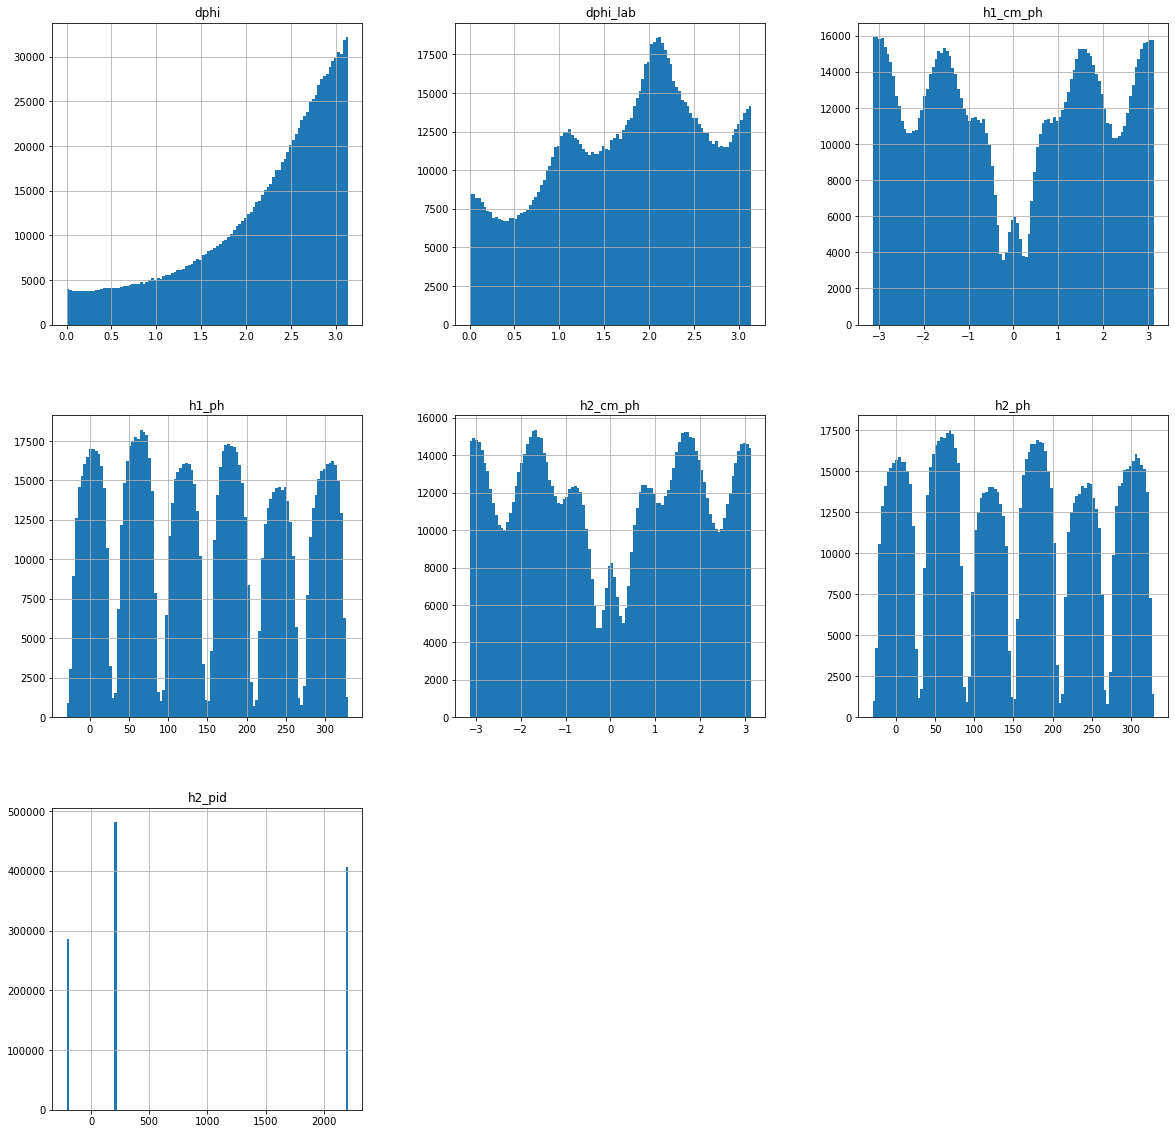

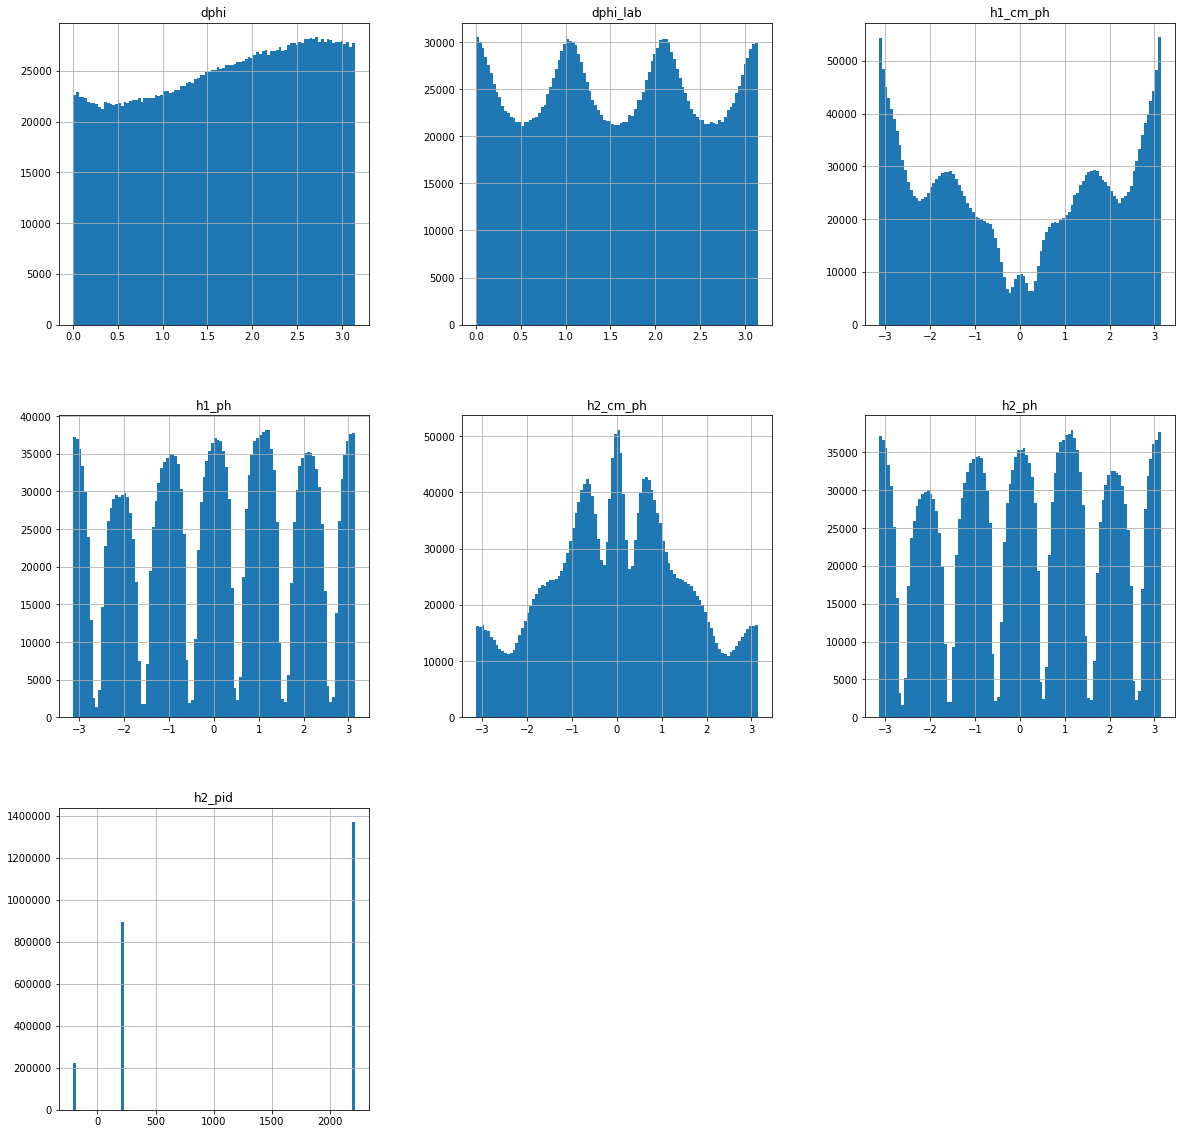

In [40]:
df['D_C'].query('h2_z>0.2').hist(figsize=(20,20),bins=100,column=['dphi_lab','dphi','h1_ph','h2_ph','h1_cm_ph','h2_cm_ph','h2_pid'])
df['D_C_mix'].query('h2_z>0.2').hist(figsize=(20,20),bins=100,column=['dphi_lab','dphi','h1_ph','h2_ph','h1_cm_ph','h2_cm_ph','h2_pid'])

plt.show()

## MC

In [31]:
import root_pandas
from root_pandas import read_root
from root_pandas import to_root 

## Save dataframes to ROOT files

In [ ]:
# to_root(df['Pb'],'Pairs_Pb.root', key='Pb')
# to_root(df['Pb_mix'],'Pairs_Pb.root', key='Pb_mix',mode='a')
# to_root(df['Pb_trigger'],'Pairs_Pb.root', key='Pb_trigger', mode='a')
# to_root(df['D_Pb'],'Pairs_Pb.root', key='D_Pb',mode='a')
# to_root(df['D_Pb_mix'],'Pairs_Pb.root', key='D_Pb_mix',mode='a')
# to_root(df['D_Pb_trigger'],'Pairs_Pb.root', key='D_Pb_trigger', mode='a')

In [ ]:
# to_root(df['Fe'],'Pairs_Fe.root', key='Fe')
# to_root(df['Fe_mix'],'Pairs_Fe.root', key='Fe_mix',mode='a')
# to_root(df['Fe_trigger'],'Pairs_Fe.root', key='Fe_trigger', mode='a')
# to_root(df['D_Fe'],'Pairs_Fe.root', key='D_Fe',mode='a')
# to_root(df['D_Fe_mix'],'Pairs_Fe.root', key='D_Fe_mix',mode='a')
# to_root(df['D_Fe_trigger'],'Pairs_Fe.root', key='D_Fe_trigger', mode='a')

In [ ]:
# to_root(df['C'],'Pairs_C.root', key='C')
# to_root(df['C_mix'],'Pairs_C.root', key='C_mix',mode='a')
# to_root(df['C_trigger'],'Pairs_C.root', key='C_trigger', mode='a')
# to_root(df['D_C'],'Pairs_C.root', key='D_C',mode='a')
# to_root(df['D_C_mix'],'Pairs_C.root', key='D_C_mix',mode='a')
# to_root(df['D_C_trigger'],'Pairs_C.root', key='D_C_trigger', mode='a')

In [32]:
for target in ['Fe']:
    to_root(df['%s'%target],'Pairs_%s.root'%target, key='%s'%target)
    to_root(df['%s_mix'%target],'Pairs_%s.root'%target, key='%s_mix'%target,mode='a')
    to_root(df['%s_trigger'%target],'Pairs_%s.root'%target, key='%s_trigger'%target, mode='a')
    to_root(df['D_%s'%target],'Pairs_%s.root'%target, key='D_%s'%target,mode='a')
    to_root(df['D_%s_mix'%target],'Pairs_%s.root'%target, key='D_%s_mix'%target,mode='a')
    to_root(df['D_%s_trigger'%target],'Pairs_%s.root'%target, key='D_%s_trigger'%target, mode='a')

In [ ]:
for target in ['C','D']:
    to_root(df_mc['%s'%target],'MC_Pairs_%s.root'%target, key='%s'%target)
    to_root(df_mc['%s_mix'%target],'MC_Pairs_%s.root'%target, key='%s_mix'%target,mode='a')
    to_root(df_mc['%s_trigger'%target],'MC_Pairs_%s.root'%target, key='%s_trigger'%target, mode='a')


In [ ]:
df['Pb_trigger'].hist(figsize=(12,12),bins=100)
plt.show()

## See distributions